<a href="https://colab.research.google.com/github/eniompw/Llama-from-Scratch/blob/main/llama_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch import nn
import torch
import numpy as np
import time
from torch.nn import functional as F
import pandas as pd

In [ ]:
!wget https://raw.githubusercontent.com/bkitano/llama-from-scratch/main/input.txt
lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

--2023-08-25 18:39:45--  https://raw.githubusercontent.com/bkitano/llama-from-scratch/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-08-25 18:39:45 (17.0 MB/s) - ‘input.txt’ saved [1115394/1115394]

First Citizen:
Before we proce


In [ ]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

vocab size: 65


torch.Size([1115394])

In [ ]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    'd_model': 128,
    'n_layers': 4,
    'context_window': 16,
    'n_heads': 8,
    'epochs': 1000,
    'batch_size': 1,
    'log_interval': 10
}

config = MASTER_CONFIG

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [ ]:
class RoPEAttention_wMask(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R[:m, ...])).transpose(0,1)

        activations, attn_weights = self.multihead(
            q_out,k_out,v_out,
            attn_mask=nn.Transformer.generate_square_subsequent_mask(m),
            is_causal=True
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

In [ ]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [ ]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEAttention_wMask(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [ ]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

In [ ]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

In [ ]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [ ]:
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

model params: 733382
Epoch 0 | val loss 4.159 | Time 0.029 | ETA in seconds 2.926
Epoch 10 | val loss 3.957 | Time 0.285 | ETA in seconds 28.181
Epoch 20 | val loss 3.625 | Time 0.277 | ETA in seconds 27.158
Epoch 30 | val loss 3.204 | Time 0.295 | ETA in seconds 28.640
Epoch 40 | val loss 3.304 | Time 0.269 | ETA in seconds 25.835
Epoch 50 | val loss 3.320 | Time 0.287 | ETA in seconds 27.300
Epoch 60 | val loss 3.313 | Time 0.371 | ETA in seconds 34.867
Epoch 70 | val loss 3.210 | Time 0.365 | ETA in seconds 33.965
Epoch 80 | val loss 2.882 | Time 0.371 | ETA in seconds 34.098
Epoch 90 | val loss 3.095 | Time 0.362 | ETA in seconds 32.977
Epoch 100 | val loss 2.879 | Time 0.429 | ETA in seconds 38.621
Epoch 110 | val loss 3.123 | Time 0.282 | ETA in seconds 25.093
Epoch 120 | val loss 3.078 | Time 0.289 | ETA in seconds 25.423
Epoch 130 | val loss 2.916 | Time 0.277 | ETA in seconds 24.135
Epoch 140 | val loss 3.081 | Time 0.293 | ETA in seconds 25.187
Epoch 150 | val loss 2.832 | Ti

<Axes: >

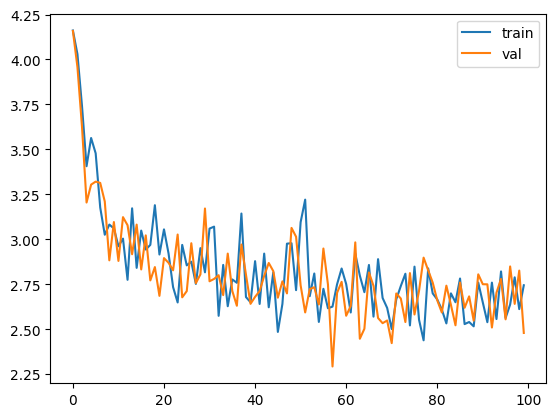

In [ ]:
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)